# Pattern and probability computations for Cloud Botany shallow convection simulations
Working with a downloaded 256x256 2D LWP subset (every 6th gridpoint or pixel), every 10th time (200 minutes apart), all grabbed/saved by another notebook in this folder. Also use profile data, also grabbed in the downloads notebook. 

[Defining functions for pattern characterization](#Functions)

[Pattern measures performed](#Pattern_measures)

[2D information H/Smax & predictors & impacts](#H_predictors_impacts)

[A horiz-mean dataset of all that, ds_patterns](#ds_patterns)

[Pattern plots (103 page PDF foa all sims)](#PatternPlots)

[Analysis: pathways to greater H, and impacts of it](#Pathways)

#### Not used in this shallow convection notebook 
[Composite map of an array around all nonzero values](#Composite_prob)

[Fits in r and theta of the above](#CompProbFits)


In [ ]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np # https://github.com/numpy/numpy/issues/23775
import pandas as pd

------------
<h2 id="Functions">Functions for pattern characterization</h2>
# Functions for pattern characterization 

In [46]:
def information(PDF): 
    # just make sure it is a PDF (sums to one) 
    PDF = PDF/np.sum(PDF)

    # information subtracts a same-sized but uniform PDF, p=1/size(PDF) 
    nullPDF = 1./ np.size(PDF)

    # for log2, need to make sure the zeros are replaced with 1e-99
    Smax = -np.log2(nullPDF)
    H = Smax - (-np.sum( PDF * np.log2(PDF+1e-99)))
    
    return(H)

In [47]:
def norm_information(PDF): 
    # just make sure it is a PDF (sums to one) 
    PDF = PDF/np.sum(PDF)

    # information subtracts a same-sized but uniform PDF, p=1/size(PDF) 
    nullPDF = 1./ np.size(PDF)

    # for log2, need to make sure the zeros are replaced with 1e-99
    Smax = -np.log2(nullPDF)
    H = Smax - (-np.sum( PDF * np.log2(PDF+1e-99)))
    
    return(H/Smax)

In [48]:
# composite_around_nonzeros_periodic(array) function 
# make an instantaneous composite array, averaged 
# spatially relative to shifted-to=center nonzero values 
# for any 2D arrray

def composite_around_nonzeros_periodic(spotty):
    # Loop over locations, roll the array, and tally the sum of a categorical (0 or 1) array

    composite_sum = spotty.copy()*0.  # right sized container of zeros
    composite_num = spotty.copy()*0  # right sized container of zeros

# Locations to center the composite around 
    i_vals, j_vals = np.where(spotty) 
    NX,NY = spotty.shape
    halfNX = int(NX/2); halfNY = int(NY/2)

# Loop over nonzero ("active") locations, roll the array, and tally the sum 
    for active in range( len(i_vals) ):
        rolled = np.roll(spotty, (halfNX-i_vals[active], halfNY-j_vals[active]), axis=(0, 1))
        composite_sum += rolled
        composite_num += 1 
    
# Final result:
        composite = composite_sum / composite_num

    return(composite)

----------------
<h2 id="Pattern_measures">Measures of patterns</h2>

## mesoscale pattern information H or nH = H/Smax, anisotropy index A 
### in 256x256 = 1/6 downsampling of original 1536x1536 x,y array size 

What do I mean by pattern information? Deviations from maximum entropy (uniformity) of a PDF. But what PDF? Here I want to measure *spatial* nonuniformity of cloudiness, at *coarse* scales, setting aside *total cloudiness* variations across all the snapshots. For this reason, my PDF should be **the probability of each pixel being in the upper decile of LWP**, which can then be coarse-grained (block-averaged) to various resolutions. Of course IF CLOUD COVER IS LESS THAN 10%, this will fail (the decile coverage will be bounded above by the cloud cover itself). Discard those scenes.  

In [42]:
# 2D dataset contains lwp and surfprec, some nan blocks due to wifi badness 
# ds_2D = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/CloudBotany_patterns256_twp_Navwifi.nc')
# ds_2D = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/CloudBotany_patterns256_UMwifi.nc')

ds_2D = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/CloudBotany_patterns256.nc')

In [ ]:
# Big Slow Loop to compute pattern H nd Hn = H/Smax, by rebinning scale octave 
#  (powers of 2 rebinning from 256)
# (103, 18, 8) is shape of result (MEM, TIME, OCTAVE)

err=junk # prevents careless loop execution unless commented

octaves = 2**np.linspace(0,7,8) # REBIN 2x, 4x, ... floats 2.,4,8,...128.
uni_p = 1./(256. /octaves)**2   # uniform probability, 1 divided by NBINS
Smaxoc = -np.log2(uni_p)        # maximum entropy Smax of the above 

# Structure of results: 
NSIM = ds_2D.member.values.size   # number of simulations 
NT = 18                           # 200min = 3:20 time gap, "time=slice(None, None, 10)"
NOCT = octaves.size
# time axis for plot hh 
hh = np.arange(NT)*200./60.  # hours

# Information entropy values H: container for results of loop 
Hs = np.zeros( (NSIM,NT,NOCT) )
nHs= np.zeros( (NSIM,NT,NOCT) ) 

# THE BIG LOOP over ensemble members (simulations)
for mem in range( ds_2D.member.size ):
    print('simulation ',mem)
    for it in range(2,18):   # times 200 minutes apart, not the first two 
        sq = ds_2D.lwp[mem][it]
        
# create 'active' and 'p_active' arrays: 1 for top 10% of LWP, all others 0
        decile9 = np.sort( np.ravel( sq.values) )[9*sq.size//10]   # 9/10 decile 
        active = (sq > decile9)
        p_active = active/np.sum(active) # probability, because it sums to 1
        
# LOOP over coarsening blocks, resampled back onto 256x256 grid 
        for isc,scale in enumerate(octaves): 
            blocksize = int(scale)
            cp_active = p_active.coarsen(xt=blocksize, yt=blocksize).mean().\
                interp_like(active, method='nearest', kwargs={"fill_value": "extrapolate"})

# Collect the result: information H in bits, from the coarsened p_active array 
            Hs[mem,it,isc] = information(cp_active)
            nHs[mem,it,isc]= norm_information(cp_active)    # H/Smax
                
## Set Hs for problematic cases: all white, all black (uniform), or if quintile is zero
            if( np.isnan(sq).any() ):  # if any missing data nan
                Hs[mem,it,isc] = 0 #float('NaN')   # no information is present but let nan propagate thru
                nHs[mem,it,isc] = 0 #float('NaN')   # no information is present but let nan propagate thru
            if( (sq == 0).sum() > 0.9*65536 ):      # if cloud fraction is < 10% 
                Hs[mem,it,isc] = 0 #float('NaN')   # declare it zero or NaN 
                nHs[mem,it,isc] = 0 #float('NaN')   # declare it zero or NaN 

In [346]:
# set normalized information values of 1 to zero 
nHs = np.where(nHs>0.99,0,nHs)

### Anisotropy is a bit complicated, uses fft(LWP decile prob) in cylindrical coordinate
max/mean of the variance of p_active (the probability a cell is in the upper decile of LWP), in the angular domain, for domain total wavenumbers of say 1-16, similar to the 32 boxes of oct=3 coarse-graining chosen for H plots below. 

In [129]:
# def calc_anisotropy(mem,it,doplot=True,doprint=True,min_wavenumber=2,max_wavenumber=16) 
# CODE FOR MANUALLY SELECTED CASE but also loop over cases 
# create 'active' and 'p_active' arrays: 1 for top 10% of LWP, all others 0
# input is member number and time in 200min increments

def calc_anisotropy(mem,it,doplot=True,doprint=True,min_wavenumber=2,max_wavenumber=16):   
    sq = ds_2D.lwp[mem][it]
    decile9 = np.sort( np.ravel( sq.values) )[9*sq.size//10]   # 9/10 decile 
    active = (sq > decile9)
    p_active = active/np.sum(active) # probability, because it sums to 1
    
    from scipy.fft import fft2, fftshift
    
    image_size = p_active.shape[0]
    
    # Apply Fourier Transform
    fft_result = fft2(p_active.values)
    
    # Shift zero frequency components to the center
    fft_result_shifted = fftshift(fft_result)
    
    # Calculate amplitude
    amplitude = np.abs(fft_result_shifted)
    
    # Create 2D wavenumber array
    kx = np.fft.fftshift(np.fft.fftfreq(image_size, d=1/image_size)) 
    ky = np.fft.fftshift(np.fft.fftfreq(image_size, d=1/image_size))
    kx, ky = np.meshgrid(kx, ky)
    
    # Calculate total wavenumber array
    wavenumbers = np.sqrt(kx**2 + ky**2)
    
    # Calculate the polar coordinates
    radius = np.sqrt(kx**2 + ky**2)
    theta = np.arctan2(ky, kx)
    
    # Average the amplitude where the TOTAL wavenumber is between 2 and 16
    in_k_range = (radius>min_wavenumber) & (radius<max_wavenumber)
    
    # Create theta bins
    num_bins = 36  # 10 degrees each bin 
    theta_bins = np.linspace(np.min(theta), np.max(theta), num_bins + 1)
    
    # Calculate the mean amplitude in each theta bin
    mean_amplitude = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = (theta >= theta_bins[i]) & (theta < theta_bins[i + 1])
        mean_amplitude[i] = np.mean(amplitude * in_k_range * in_bin)

    if(doplot): 
        # Plot the original image, amplitude, the annulus, and the fitted sinusoidal curve
        plt.figure(figsize=(16, 4))
        
        plt.subplot(141)
        plt.pcolormesh(p_active, cmap='viridis')
        plt.title('Original Image')
        
        plt.subplot(142)
        plt.pcolormesh(np.log1p(amplitude), cmap='viridis')
        plt.title('Log Amplitude Spectrum')
        
        plt.subplot(143)
        plt.pcolormesh(kx,ky, np.log1p(amplitude), cmap='viridis')
        ax = plt.gca()
        ax.set_xlim([-30, 30])
        ax.set_ylim([-30, 30])
        plt.contour(kx,ky,radius, levels=[min_wavenumber, max_wavenumber], colors='r', linewidths=2)
        plt.title('Wavenumber Annulus for anisotropy')
        
        plt.subplot(144)
        plt.plot(theta_bins[:-1] *180/3.1415 + 360/num_bins/2, mean_amplitude)
        plt.title('amplitude vs. angle in wavenumber annulus')
        
        plt.plot() 
        
        plt.tight_layout()
        plt.show()
        
    
    argmx = np.argmax(mean_amplitude)
    maxangle = theta_bins[ argmx ]
    maxangledeg = theta_bins[ argmx ] *180/3.1415 + 360/num_bins/2

# Compute information of angular distribtion of variance, normalized by Smax 
    Smax_angledist = -np.log2( 1.0/np.size(mean_amplitude) )
    anisotropyH = information(mean_amplitude) / Smax_angledist

    angvarpeak = np.max(mean_amplitude)/np.mean(mean_amplitude)

    if(doprint): 
        print('angle (degrees) is ', maxangledeg, maxangledeg+180)
        print('varpeak, ainsotropyH is ', angvarpeak, anisotropyH )

    return( angvarpeak )

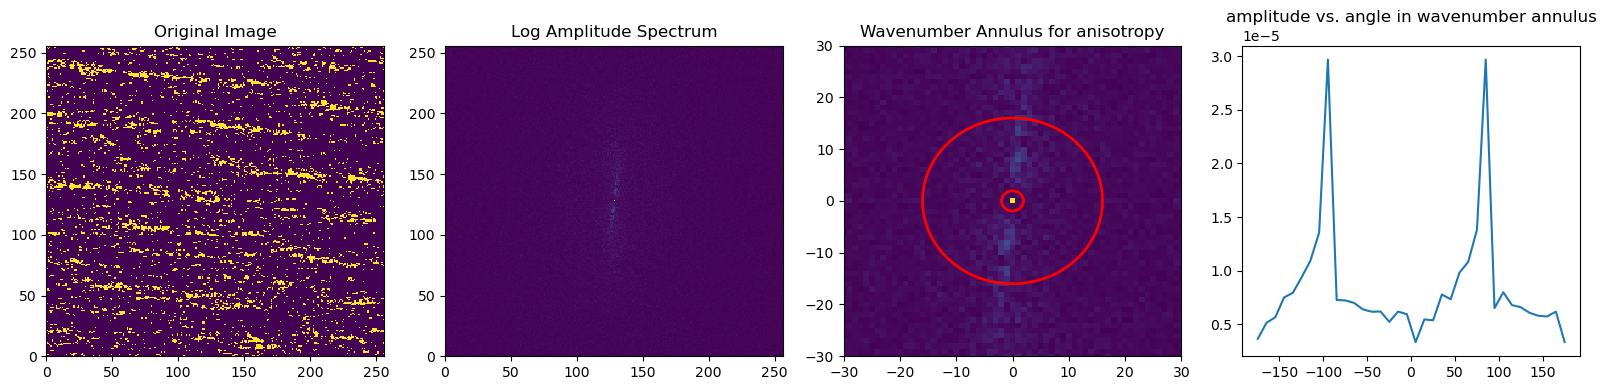

angle (degrees) is  -94.65479471926312 85.34520528073688
varpeak, ainsotropyH is  3.572145676312869 0.04588097991870306


3.572145676312869

In [224]:
# Maximum A value case 83,4
calc_anisotropy(83,3)
#calc_anisotropy(96,14)

In [130]:
# Loop to calculate A for all cases and times, put in array As 

# Anisotropy strength A: make container for results of loop 
As = np.zeros( (NSIM,NT) )

# THE BIG LOOP over ensemble members (simulations)
for mem in range( ds_2D.member.size ):
    for it in range(ds_2D.time.size):   # times 200 minutes apart, not the first two 
        As[mem,it] = calc_anisotropy(mem,it,doplot=False,doprint=False)

<h2 id="H_predictors_impacts">Make domain-mean dataset with pattern and other info</h2>

#### The mesoscale patterns are characterized by nH for the 5km scale, & A
Compute them and put them in ds_profiles, an area-averaged dataset with initial fields chosen in the download notebook and some derived fields merged in for convenience of analysis later 

In [417]:
# Grab "profiles_thermke" dataset (domain means, is its defining characteristic)
# thermo-oriented dataset, I don't need u,v here, anisotropy is from shear but COMPLICADO
ds_profiles = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/' +\
                              'CloudBotany_profiles_thermke.nc')

# For clarity, subtract means to better see anomalies and perturbations
# make anomaly a and then vertical perturbation p theta-v data variable: 
# thva is diff from time mean or initial, thvap is deviation from vertical mean at each time
ds_profiles['thva']  = ds_profiles['thv']  - ds_profiles['thv'].isel(time=0)
ds_profiles['thvap'] = ds_profiles['thva'] - ds_profiles['thva'].mean(dim='zt')

# Anomalous density (from initial time)
ds_profiles['rhoa'] = ds_profiles['rhof'] - ds_profiles['rhof'].isel(time=0)

# Fraction of TKE in the vertical component 
ds_profiles['HTKE'] = (ds_profiles['u2r']+ds_profiles['v2r']) 
ds_profiles      #.wthvt[10][10].plot() # typical value 0.01

<xarray.Dataset>
Dimensions:  (member: 103, time: 720, zm: 175, zt: 175)
Coordinates:
  * member   (member) int32 1 2 3 4 5 6 7 8 9 ... 95 96 97 98 99 100 101 102 103
  * time     (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
  * zm       (zm) float32 0.0 15.0 30.0 45.3 ... 6.772e+03 6.854e+03 6.938e+03
  * zt       (zt) float32 7.5 22.5 37.65 52.95 ... 6.813e+03 6.896e+03 6.98e+03
Data variables: (12/15)
    wthvt    (member, time, zm) float32 ...
    ql       (member, time, zt) float32 ...
    ql2r     (member, time, zt) float32 ...
    cfrac    (member, time, zt) float32 ...
    w2r      (member, time, zm) float32 ...
    u2r      (member, time, zt) float32 ...
    ...       ...
    skew     (member, time, zm) float32 ...
    thltend  (member, time, zt) float32 ...
    thva     (member, time, zt) float32 0.0 0.0 0.0 ... -0.2471 -0.2745 -0.3192
    thvap    (member, time, zt) float32 0.0 0.0 0.0 0.0 ... 0.4265 0.3991 0.3544
    rhoa     (member, time, zt) float32 0.0 0.0 0.0 ... -0.000326 -0.0002516
    HTKE     (member, time, zt) float32 0.001397 0.00136 ... 0.003369 0.003365
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.423
    title:    profiles.001.nc

In [493]:
# Make profile t-z plots in AllSimulations.time-heights.pdf : a dataset overview 
from matplotlib.backends.backend_pdf import PdfPages

vars = list(ds_profiles.keys()) 
vars = ['wthvt','thva','ql','w2r','HTKE'] # 5 variables and then skew 

#with PdfPages('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/AllSimulations.time-heights.pdf') as pdf:
with PdfPages('AllSims.time-heights.pdf') as pdf:

    for imem,mem in enumerate(ds_profiles.member):    
        # All 5 variables above 
        plt.figure( figsize=(10,14) )
        for i,var in enumerate(vars): 
            plt.subplot(6,1,i+1)
            ds_profiles[var][imem][::3][::3].transpose().plot() # Subsample 3x in time, height 
            # plt.ylim([0,5000])
            plt.title( var + ', member= '+str(imem+1) )
            
#skew: clip colors 
        plt.subplot(6,1,6)
        ds_profiles['skew'][imem][::3][::3].transpose().plot(vmax=3) # fixed colorbar for skew 
        plt.ylim([0,5000])
        plt.title( 'skew' + ', member= '+str(imem+1) )
        plt.tight_layout()
        pdf.savefig()
        plt.close()

Text(0.5, 1.0, 'skew, member= 84')

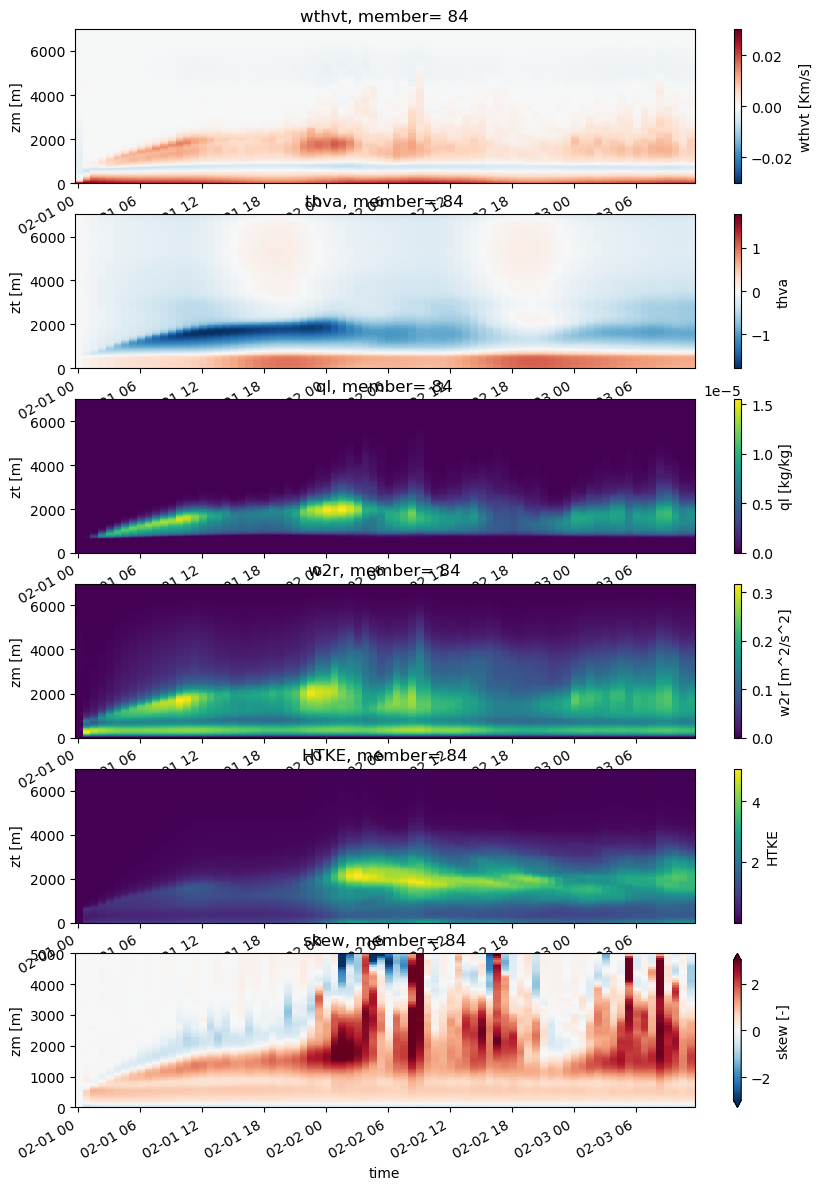

In [520]:
        # one page of above, here in in notebook 
        imem = 83
        plt.figure( figsize=(10,14) )
        for i,var in enumerate(vars): 
            plt.subplot(6,1,i+1)
            ds_profiles[var][imem][::3][::3].transpose().plot() # Subsample 3x in time, height 
            plt.title( var + ', member= '+str(imem+1) )
            
#skew: clip colors 
        plt.subplot(6,1,6)
        ds_profiles['skew'][imem][::3][::3].transpose().plot(vmax=3) # fixed colorbar for skew 
        plt.ylim([0,5000])
        plt.title( 'skew' + ', member= '+str(imem+1) )

----------------
# Convection's KE budget, & raison d'etre (mean PE lowering)

### 1. Compute KE generation rate by [w'b'], and KE (vertically integrated) 

$ d/dt<[KE]> = <[w * dw/dt]> = <[wb]> = <  w' \cdot \theta_v' > g/ \theta_{v_0}  $ = wthvt *g_over_theta


In [523]:
# Time integrate (cumulate) the vertical mean KE source from buoyancy flux
# approximately constant theta-v, lazy work since thv is on staggered grid
g_over_th0 = 9.81/290 

# Integrate BF over zm: lazy g_over_th0 since thv and BF are on staggered grid, and ignoring rho(z)
ds_profiles['BF'] = g_over_th0 * ds_profiles.wthvt.mean('zm')
ds_profiles['IBF'] = ds_profiles.wthvt.mean('zm').cumulative_integrate('time','s') *g_over_th0

ds_profiles['VKE'] = ds_profiles.w2r.mean('zm')/2
ds_profiles['HKE'] = ds_profiles.HTKE.mean('zt')/2

### 2. Compute PE time evolution, & rad. PE tendency ("forcing") 

$ <[PE']> = \int (gz \rho') dz = \int gz \rho_o (\theta_v'/\theta_{v_0}) dz$ = gz* rhof* (thltend/thl)

I have thv but not thl at hand, close enough, both are near enough plain theta as a mere gentle height-dependence denominator for normalization.

In [427]:
# PE time series, from anomalous density rhoa: units will be J m-2
ds_profiles['PEa'] = 9.8*( (ds_profiles.rhoa)*(ds_profiles.zt) ).integrate('zt')

# Use heating rate to estimate radiative part of that time series
ds_profiles['PEdot_rad'] = -9.8*( (ds_profiles.rhof)*(ds_profiles.zt)   * \
                                 ds_profiles.thltend / ds_profiles.thv ).integrate('zt')

# Time derivative of state variable PE: notice time steps are 5 minutes apart 
# '2020-02-01T00:05:00.000000000', '2020-02-01T00:10:00.000000000',...
ds_profiles['PEadot'] = ds_profiles['PEa'].diff('time') / (5*60)   # units of Wm-2

In [428]:
# Test plots for the above, with some meaning 

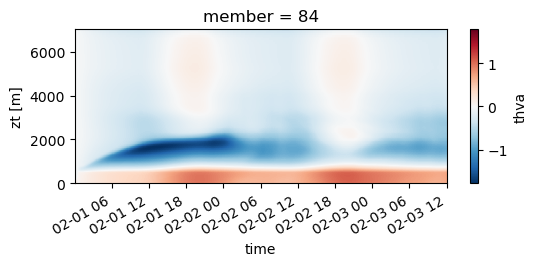

In [492]:
imem=83
ds_profiles.thva[imem,:,:].transpose().plot(size=2,aspect=3); 

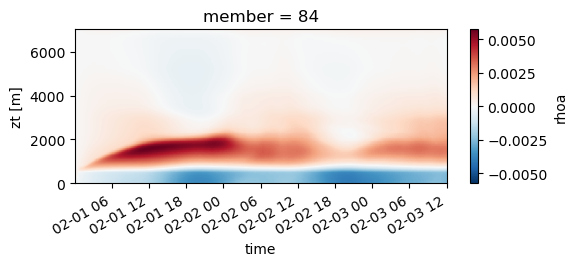

In [439]:
# Density profile differences from initial for mem=83
ds_profiles.rhoa[imem,:,:].transpose().plot(size=2,aspect=3); 

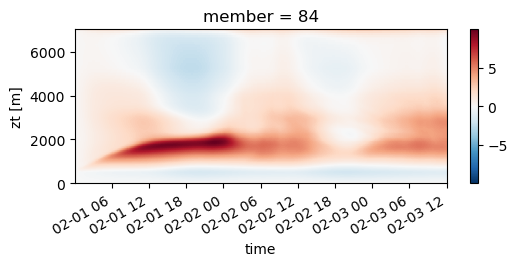

In [487]:
# Z-weighted density profile differences from initial for mem=83
((ds_profiles.rhoa)*(ds_profiles.zt))[83].transpose().plot(size=2,aspect=3); 

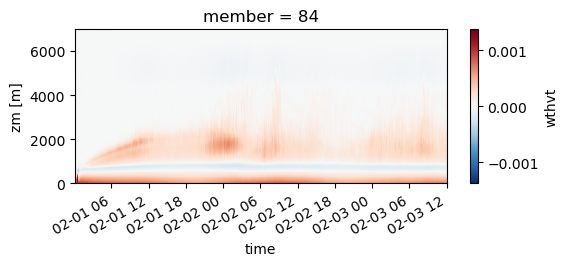

In [488]:
# BF is a tendency of VKE or w'w', with g/thv factor, altitude by altitude 
# lazy g_over_th0 since thv and BF are on staggered grid 
(g_over_th0 * ds_profiles.wthvt[83,1:,:]).transpose().plot(size=2,aspect=3); 

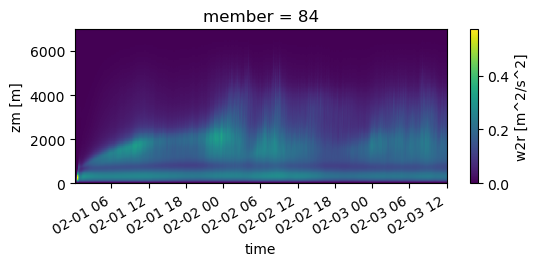

In [489]:
(ds_profiles.w2r)[83,1:,:].transpose().plot(size=2,aspect=3); 

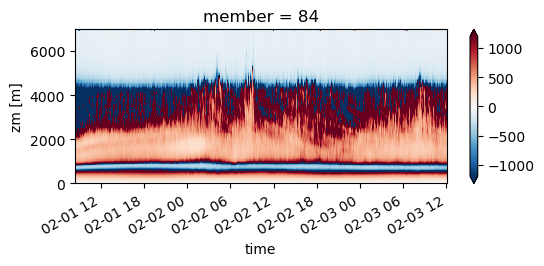

In [500]:
# w2r/BF, set top on color scale to 1200s (20 mins) for VKE residence time 
((ds_profiles.w2r)[83,100:,:]/2/(g_over_th0 * ds_profiles.wthvt[83,100:,:]) )\
        .transpose().plot(size=2,aspect=3, vmax=1200); 

In [501]:
ds_profiles

<xarray.Dataset>
Dimensions:    (member: 103, time: 720, zm: 175, zt: 175)
Coordinates:
  * member     (member) int32 1 2 3 4 5 6 7 8 9 ... 96 97 98 99 100 101 102 103
  * time       (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T12:00:00
  * zm         (zm) float32 0.0 15.0 30.0 45.3 ... 6.772e+03 6.854e+03 6.938e+03
  * zt         (zt) float32 7.5 22.5 37.65 ... 6.813e+03 6.896e+03 6.98e+03
Data variables: (12/18)
    wthvt      (member, time, zm) float32 ...
    ql         (member, time, zt) float32 ...
    ql2r       (member, time, zt) float32 ...
    cfrac      (member, time, zt) float32 ...
    w2r        (member, time, zm) float32 0.0 5.471e-05 ... 5.767e-05 1.475e-05
    u2r        (member, time, zt) float32 ...
    ...         ...
    thvap      (member, time, zt) float32 0.0 0.0 0.0 ... 0.4265 0.3991 0.3544
    rhoa       (member, time, zt) float32 0.0 0.0 0.0 ... -0.000326 -0.0002516
    HTKE       (member, time, zt) float32 0.001397 0.00136 ... 0.003369 0.003365
    PEa        (member, time) float32 0.0 1.438e+03 ... 1.095e+05 1.084e+05
    PEdot_rad  (member, time) float32 17.31 17.3 17.29 ... 8.421 8.093 7.771
    PEadot     (member, time) float32 nan 4.794 4.94 ... -3.62 -3.372 -3.938
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.423
    title:    profiles.001.nc

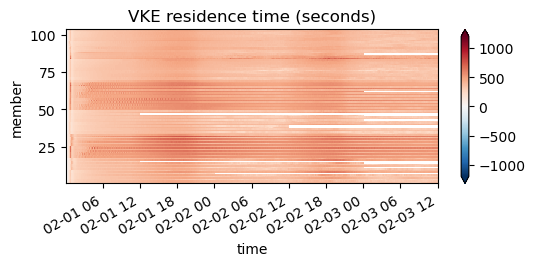

In [526]:
### Compute vertically averaged 'KE efficiency' measures 
# residence time of w'w' = <w2r>/<wthvt>
tau = ds_profiles.VKE / ds_profiles.BF

tau.plot(size=2,aspect=3, vmax=1200); plt.title("VKE residence time (seconds)");

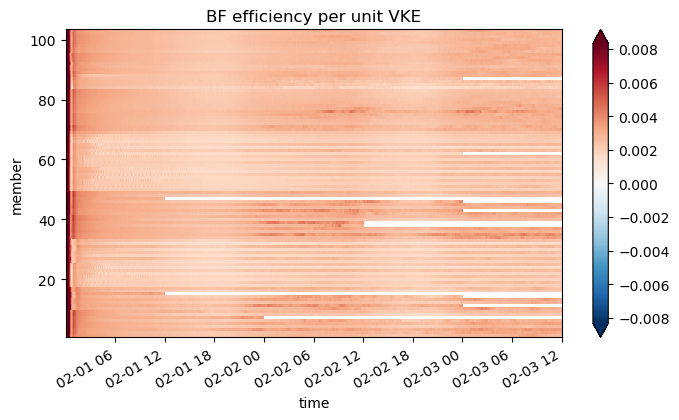

In [560]:
# The inverse of tau is efficiency, thv flux per unit w'w' #those granules are interesting
# This is a lag-zero product or quotient

(1.0/tau).plot(size=4,aspect=2, vmax=1./120.); plt.title("BF efficiency per unit VKE");

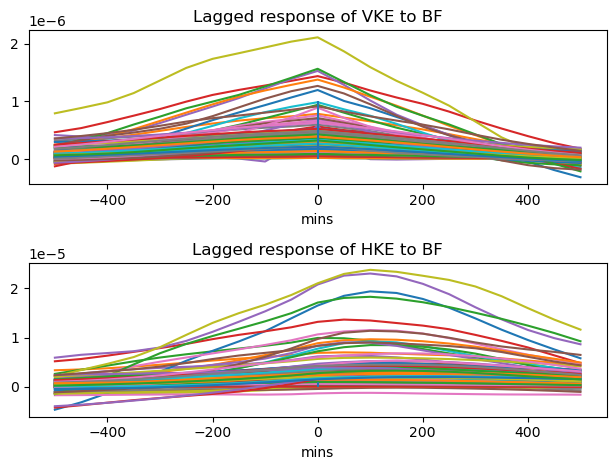

In [574]:
# Lagged covariance between BF and VKE, HKE

lags = np.linspace(-100,100,21)  # time lags in 5 minute increments 
lag_covH=[] # container for result
lag_covV=[] # container for result

for ilag,lag in enumerate(lags): 
    
    lag_covH.append (xr.cov(ds_profiles.BF, ds_profiles.HKE.shift(time=-int(lag)), dim='time', ) )
    lag_covV.append (xr.cov(ds_profiles.BF, ds_profiles.VKE.shift(time=-int(lag)), dim='time', ) )

plt.subplot(211)
plt.plot(lags*5, lag_covV); plt.xlabel('mins'); plt.title('Lagged response of VKE to BF');
plt.vlines(0,ymin=0,ymax=1e-6);

plt.subplot(212)
plt.plot(lags*5, lag_covH); plt.xlabel('mins'); plt.title('Lagged response of HKE to BF');
plt.vlines(0,ymin=0,ymax=1e-6);
plt.tight_layout()

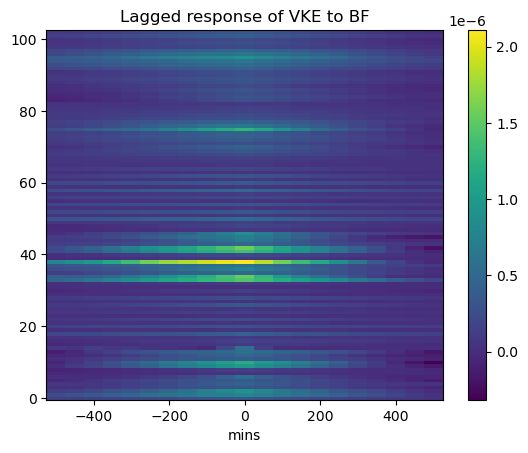

In [578]:
plt.pcolor(lags*5, range(103), np.transpose(lag_covV)); plt.colorbar()
plt.xlabel('mins'); plt.title('Lagged response of VKE to BF');

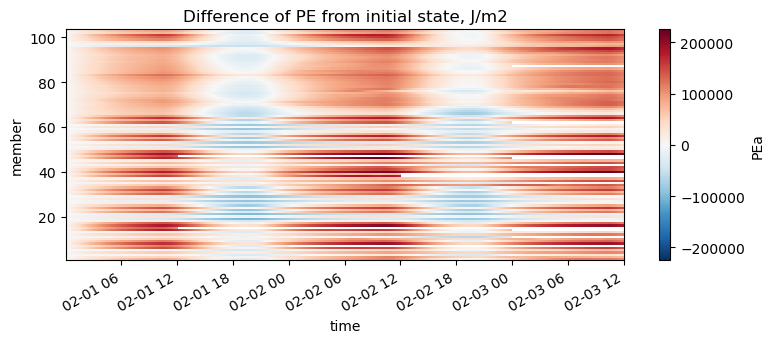

In [486]:
ds_profiles['PEa'].plot(size=3,aspect=3); 
plt.title('Difference of PE from initial state, J/m2');

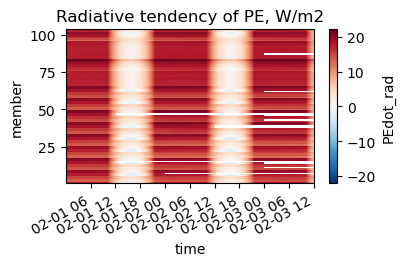

In [434]:
ds_profiles['PEdot_rad'].plot(size=2,aspect=2); 
plt.title('Radiative tendency of PE, W/m2');

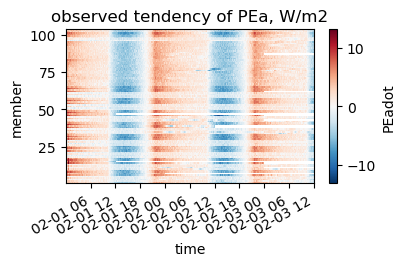

In [437]:
ds_profiles['PEadot'].plot(size=2,aspect=2); 
plt.title('observed tendency of PEa, W/m2');

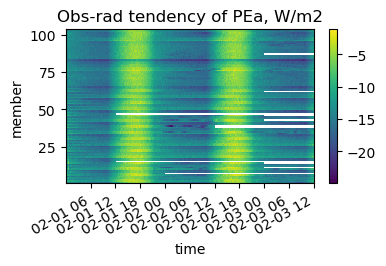

In [438]:
(ds_profiles['PEadot'] -ds_profiles['PEdot_rad']).plot(size=2,aspect=2); 
plt.title('Obs-rad tendency of PEa, W/m2');

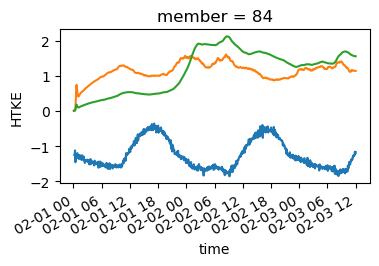

In [455]:
# Time series of energy budget related quantities, rescaled for plot arbitrarily 

(0.1*(ds_profiles['PEadot'] -ds_profiles['PEdot_rad']))[imem].plot(size=2,aspect=2)
(10*ds_profiles.w2r)[imem].mean('zm').plot()
ds_profiles.HTKE[imem].mean('zt').plot()

-------------

<h2 id="ds_patterns">Make ds_patterns dataset of H, predictors, impacts every 200 mins</h2>

#### Pattern aspects
H5, Hn5, dHn5, Anis 

#### Candidate predictors and impacts
PR, IP, BF, IBF, w2r or VKE, PEa, PEadot, PEdot_rad

In [398]:
# Add precipitation variables 

ds_profiles['PR'] = ds_2D.surfprec.mean(dim=['xt','yt'])  # precip rate 
ds_profiles['IP'] = ds_2D.surfprec.mean(dim=['xt','yt']).cumulative_integrate('time','s') 

In [401]:
ds_patterns = ds_profiles[['BF','IBF','w2r','thvap','PR','IP','PEa','PEadot','PEdot_rad']]\
                .sel(time=ds_2D.time)

ds_profiles['VKE']= 

In [402]:
# Merge H5km, Hn5km = H/Smax and its time change, Anisotropy A into ds_patterns data set 
oc=3 # Octave 3, 2^3 x 2^3 rebinning, 32x32 boxes remain, 4.8km size

# 200-minute time differences of nH5km
Hn5km = nHs[:,:,oc] # Octave 3, the 32x32 boxes of 4.8km size 
dHn5 = Hn5km * 0.0  # container for 200-minute forward time differences, zero the default
dHn5[:,0:16] = Hn5km[:,1:17] - Hn5km[:,0:16]

# Make a dictionary of coordinates so we can add them to xarray dataset 
var_dictA = {'Anis': (('member', 'time'), np.nan_to_num(As))}
var_dictH = {'H5': (('member', 'time'), Hs[:,:,oc])}
var_dictHn = {'Hn5': (('member', 'time'), Hn5km)}
var_dictdHn = {'dHn5': (('member', 'time'), dHn5)}

ds_patterns = ds_patterns.assign(**var_dictA)
ds_patterns = ds_patterns.assign(**var_dictH)
ds_patterns = ds_patterns.assign(**var_dictHn)
ds_patterns = ds_patterns.assign(**var_dictdHn)

ds_patterns

<xarray.Dataset>
Dimensions:    (member: 103, time: 18, zm: 175, zt: 175)
Coordinates:
  * member     (member) int32 1 2 3 4 5 6 7 8 9 ... 96 97 98 99 100 101 102 103
  * time       (time) datetime64[ns] 2020-02-01T00:05:00 ... 2020-02-03T08:45:00
  * zm         (zm) float32 0.0 15.0 30.0 45.3 ... 6.772e+03 6.854e+03 6.938e+03
  * zt         (zt) float32 7.5 22.5 37.65 ... 6.813e+03 6.896e+03 6.98e+03
Data variables: (12/13)
    BF         (member, time) float32 -5.263e-06 9.469e-05 ... 0.0001427
    IBF        (member, time) float64 0.0 0.9931 2.25 ... 24.56 26.63 28.45
    w2r        (member, time, zm) float32 ...
    thvap      (member, time, zt) float32 0.0 0.0 0.0 ... 0.3637 0.3439 0.3219
    PR         (member, time) float32 0.0 0.0 1.031e-17 ... 4.532e-06 2.305e-06
    IP         (member, time) float64 0.0 0.0 6.187e-14 ... 0.4443 0.6312 0.6723
    ...         ...
    PEadot     (member, time) float32 nan 2.551 1.737 ... 1.228 2.381 1.846
    PEdot_rad  (member, time) float32 17.31 17.33 17.31 ... 17.98 18.08 17.78
    Anis       (member, time) float64 0.0 1.442 1.323 ... 1.392 1.514 1.558
    H5         (member, time) float64 0.0 0.0 0.1258 ... 1.366 1.599 0.8396
    Hn5        (member, time) float64 0.0 0.0 0.007863 ... 0.09991 0.05248
    dHn5       (member, time) float64 0.0 0.007863 0.004756 ... 0.01451 0.0 0.0
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.423
    title:    profiles.001.nc

In [403]:
# SAVE modest sized ds_patterns dataset for later use without having to recompute 
ds_patterns.to_netcdf('CloudBotany_patterns_predictors.nc')

#'/~/GitHub/EvolutionaryConvection/Shallow_patterns_CloudBotany/CloudBotany_patterns_predictors.nc'

# 103 page PDF of patterns and measures

In [ ]:
# 103 page PDF with 12 panels per page, after an index page 
# Multipage PDF file https://gist.github.com/thanasi/7e08bc41e6a085cd2140
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('AllSimulations.9times.contourf.pdf') as pdf:
    vars = list(ds_pattern.keys())[0:9]
    
    # Index page of all the variables (11 currently, 4x3 has room for 12 
    plt.figure( figsize=(12,16) )
    for i,var in enumerate(vars): 
        plt.subplot(4,3,i+1)
        ds_pattern[var].plot(); plt.title(var)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
    # Loop over members, one page per member. Plot 3 variables, then 9 images (15 panels)
    for imem, member in enumerate(ds_pattern.member):

            plt.figure( figsize=(12,16) )

# top 3 plots
# IBF, IP, Anisotropy rescaled for plot 
            plt.subplot(4,3,1)
            ds_pattern['IBF'][imem].plot()
            (20*ds_pattern['IP'][imem]).plot(); 
            (20*ds_pattern['Anis'][imem]).plot(); 
            plt.ylim([0,50])
            plt.title('IBF,20*IP,10*A, mem ' + str(imem+1))
# Time series of energy budget related quantities, rescaled for plot  
            plt.subplot(4,3,2)
            (0.1*(ds_profiles['PEadot'] -ds_profiles['PEdot_rad']))[imem].plot()
            (10*ds_profiles.w2r)[imem].mean('zm').plot()
            ds_profiles.HTKE[imem].mean('zt').plot()
            plt.title('1+(PEdot-PEdotrad)/10, 10*VKE, HTKE')
            plt.ylim([-2,2.5])

# normalized H spectrum by scales of rebinning (octaves) 
            plt.subplot(4,3,3)
            plt.pcolor(ds_pattern.time, np.log2(octaves), nHs[imem].transpose() )
            plt.colorbar();
            plt.title('pattern H/Smax by scale')
        
# Time series of images every 400 minutes
            for it in range( ds_pattern.time.size //2 ): 
                plt.subplot(4,3,4 + it)
                np.sqrt(ds_2D.lwp[imem][it*2+1]).plot.contourf( \
                    cmap='gray', vmin=0, vmax=0.5, levels=[0.2,0.6], add_colorbar=False)
                plt.axis('off')
                plt.title(str(ds_2D.time[it*2+1].values)[0:16]+\
                          ': H,A= '+'{:.2f}'.format( ds_pattern.Hn5[imem][it].values ) + ' , '+\
                                    '{:.2f}'.format( ds_pattern.Anis[imem][it].values) )
                
            plt.tight_layout()
            pdf.savefig()  # saves the current figure into a pdf page


Text(0.5, 1.0, 'pattern H/Smax')

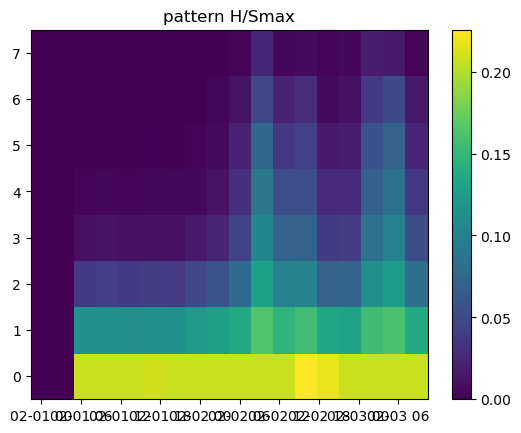

In [466]:
            plt.pcolor(ds_pattern.time, np.log2(octaves), nHs[imem].transpose() ); plt.colorbar();
            plt.title('pattern H/Smax')


# next notebook time, this one is long 

# Not utilized here: composite structure 

Another approach to anisotropy, etc. 

----------- 
<h2 id="Composite_prob">Composite of probability around all nonzero values</h2>


In [ ]:
        # test for a given imem, it 
        it=3
        imem=83
        sq = ds_2D.lwp[imem][it]
        
# create 'active' and 'p_active' arrays: 1 for top 10% of LWP, all others 0
        decile9 = np.sort( np.ravel( sq.values) )[9*sq.size//10]   # 9/10 decile 
        active = (sq > decile9)
        p_active = active/np.sum(active) # probability, because it sums to 1

        comp = composite_around_nonzeros_periodic(p_active)

In [108]:
# THE BIG LOOP over ensemble members (simulations)
#for mem in range( ds_2D.member.size ):
#    print('simulation ',mem)
#   for it in range(2,18):   # times 200 minutes apart, not the first two 
# as in cell above but not needed  

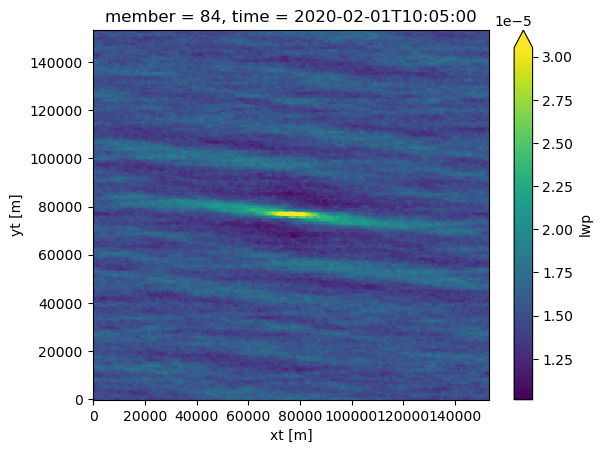

In [102]:
        comp.plot( vmax = 2./256./256. )  # max value is always 10/256./256. at the center 

<h2 id="CompProbFits">Claude.ai fits of composite p(r), p(theta)</h2>

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


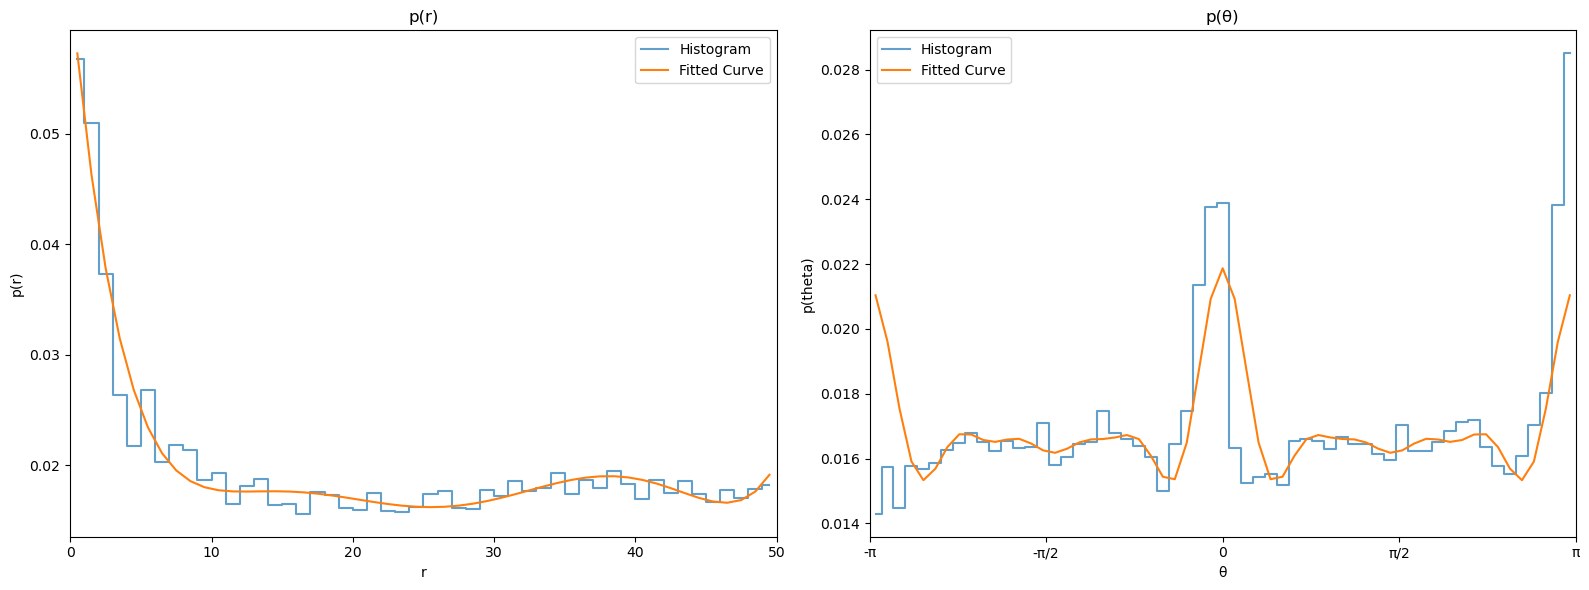

In [459]:
from scipy.optimize import curve_fit

def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def fourier_series(x, *a):
    ret = a[0]
    for deg in range(1, len(a)):
        ret += a[deg] * np.cos(deg * x)
    return ret

def fit_polar_curves(data_array, min_radius=0, max_radius=50, poly_degree=6, fourier_terms=6):
    center = np.array(data_array.shape) // 2
    y, x = np.ogrid[-center[0]:center[0], -center[1]:center[1]]
    r, theta = cartesian_to_polar(x, y)
    
    mask = (r >= min_radius) & (r <= max_radius)
    
    r_bins = np.arange(min_radius, max_radius + 1)
    hist, bin_edges = np.histogram(r, bins=r_bins, weights=data_array.values)
    bin_areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    p_r = hist / bin_areas
    p_r /= p_r.sum()
    
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    p_r_coeffs = np.polyfit(r_centers, p_r, poly_degree)
    p_r_fit = np.poly1d(p_r_coeffs)(r_centers)
    p_r_fit = np.maximum(p_r_fit, 0)
    p_r_fit /= p_r_fit.sum()
    
    theta_bins = np.linspace(-np.pi, np.pi, 60)
    p_theta, _ = np.histogram(theta[mask], bins=theta_bins, weights=data_array.values[mask])
    p_theta /= p_theta.sum()
    
    theta_centers = (theta_bins[:-1] + theta_bins[1:]) / 2
    initial_guess = [1.0] + [0.1] * (fourier_terms - 1)
    popt, _ = curve_fit(fourier_series, theta_centers, p_theta, p0=initial_guess)
    p_theta_fit = fourier_series(theta_centers, *popt)
    p_theta_fit = np.maximum(p_theta_fit, 0)
    p_theta_fit /= p_theta_fit.sum()
    
    p_r_xr = xr.DataArray(p_r_fit, coords=[('r', r_centers)], name='p(r)')
    p_theta_xr = xr.DataArray(p_theta_fit, coords=[('theta', theta_centers)], name='p(theta)')
    
    return p_r_xr, p_theta_xr, p_r, p_theta

def fit_and_plot_polar_curves(data_array, min_radius=10, max_radius=50, poly_degree=6, fourier_terms=12):
    p_r_fit, p_theta_fit, p_r_hist, p_theta_hist = fit_polar_curves(data_array, min_radius, max_radius, poly_degree, fourier_terms)
    
    r_centers = p_r_fit.r.values
    theta_centers = p_theta_fit.theta.values
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1.step(r_centers, p_r_hist, where='mid', label='Histogram', alpha=0.7)
    p_r_fit.plot(ax=ax1, label='Fitted Curve')
    ax1.set_title('p(r)')
    ax1.set_xlabel('r')
    ax1.set_xlim(min_radius, max_radius)
    ax1.legend()
    
    ax2.step(theta_centers, p_theta_hist, where='mid', label='Histogram', alpha=0.7)
    p_theta_fit.plot(ax=ax2, label='Fitted Curve')
    ax2.set_title('p(θ)')
    ax2.set_xlabel('θ')
    ax2.set_xlim(-np.pi, np.pi)
    ax2.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax2.set_xticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return p_r_fit, p_theta_fit

# Assuming your original data is in an xarray DataArray called 'data'
p_r, p_theta = fit_and_plot_polar_curves(comp, min_radius=0, max_radius=50, \
                                         poly_degree=6, fourier_terms=12)